In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [2]:
project_data = pd.read_csv('train_data.csv',nrows=50000)
resource_data = pd.read_csv('resources.csv')
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
resource_data.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

In [4]:

print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.drop('teacher_id', axis=1,inplace=True) #remove unwanted data
project_data.drop('Unnamed: 0', axis=1,inplace=True)
project_data.drop('project_submitted_datetime', axis=1,inplace=True)


project_data.head(5)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


id teacher_prefix school_state project_grade_category  \
0  p253737           Mrs.           IN          Grades PreK-2   
1  p258326            Mr.           FL             Grades 6-8   
2  p182444            Ms.           AZ             Grades 6-8   
3  p246581           Mrs.           KY          Grades PreK-2   
4  p104768           Mrs.           TX          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [6]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

Number of projects thar are approved for funding  42286 , ( 84.572 %)
Number of projects thar are not approved for funding  7714 , ( 15.428 %)


In [7]:
# Pandas dataframe grouby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [8]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
26         MT       0.764151
46         VT       0.781250
7          DC       0.785425
43         TX       0.803916
13         ID       0.804636
States with highest % approvals
   state_code  num_proposals
35         OH       0.877966
30         NH       0.879433
6          CT       0.882429
47         WA       0.888486
28         ND       0.904762


In [9]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [10]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    if top:
        temp = temp[0:top]
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

In [11]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

   school_state  project_is_approved  total       Avg
4            CA                 6013   7024  0.856065
34           NY                 2903   3393  0.855585
43           TX                 2669   3320  0.803916
9            FL                 2328   2839  0.820007
27           NC                 2006   2340  0.857265
   school_state  project_is_approved  total       Avg
39           RI                  107    126  0.849206
26           MT                   81    106  0.764151
28           ND                   57     63  0.904762
50           WY                   42     51  0.823529
46           VT                   25     32  0.781250


In [12]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                22239  26140  0.850765
3            Ms.                15124  17936  0.843220
1            Mr.                 4073   4859  0.838238
4        Teacher                  847   1061  0.798303
0            Dr.                    1      2  0.500000
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                22239  26140  0.850765
3            Ms.                15124  17936  0.843220
1            Mr.                 4073   4859  0.838238
4        Teacher                  847   1061  0.798303
0            Dr.                    1      2  0.500000


In [13]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                17185  20316  0.845885
0             Grades 3-5                14466  16968  0.852546
1             Grades 6-8                 6503   7750  0.839097
2            Grades 9-12                 4132   4966  0.832058
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                17185  20316  0.845885
0             Grades 3-5                14466  16968  0.852546
1             Grades 6-8                 6503   7750  0.839097
2            Grades 9-12                 4132   4966  0.832058


In [14]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())


In [15]:
project_data['clean_categories'] = cat_list#preprocessed project_subject_categories
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

id teacher_prefix school_state project_grade_category  \
0  p253737           Mrs.           IN          Grades PreK-2   
1  p258326            Mr.           FL             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

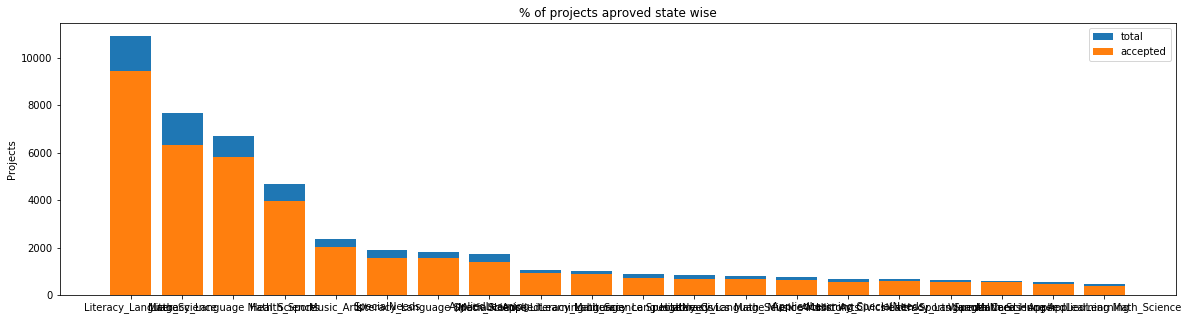

                  clean_categories  project_is_approved  total       Avg
23               Literacy_Language                 9444  10927  0.864281
31                    Math_Science                 6307   7695  0.819623
27  Literacy_Language Math_Science                 5805   6705  0.865772
8                    Health_Sports                 3976   4700  0.845957
39                      Music_Arts                 2021   2358  0.857082
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                  595    651  0.913978
14        Health_Sports SpecialNeeds                  547    633  0.864139
49                Warmth Care_Hunger                  561    606  0.925743
32      Math_Science AppliedLearning                  474    565  0.838938
4       AppliedLearning Math_Science                  386    477  0.809224


In [16]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [17]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [18]:
my_counter

Counter({'Literacy_Language': 23998,
         'History_Civics': 2689,
         'Health_Sports': 6538,
         'Math_Science': 18874,
         'SpecialNeeds': 6233,
         'AppliedLearning': 5569,
         'Music_Arts': 4699,
         'Warmth': 643,
         'Care_Hunger': 643})

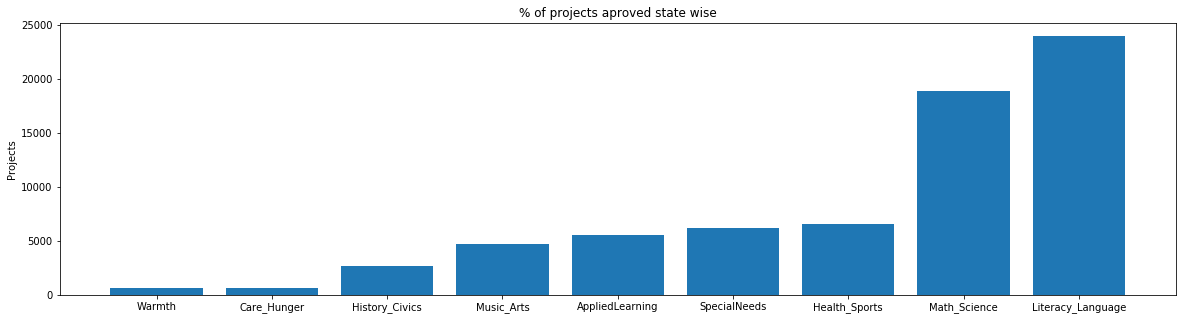

In [19]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [20]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :       643
Care_Hunger          :       643
History_Civics       :      2689
Music_Arts           :      4699
AppliedLearning      :      5569
SpecialNeeds         :      6233
Health_Sports        :      6538
Math_Science         :     18874
Literacy_Language    :     23998


In [21]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
sub_cat_list = [] #preprocessing sub_categories
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [22]:
project_data['clean_subcategories'] = sub_cat_list #preprocessed project subject subcategories
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

id teacher_prefix school_state project_grade_category  \
0  p253737           Mrs.           IN          Grades PreK-2   
1  p258326            Mr.           FL             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

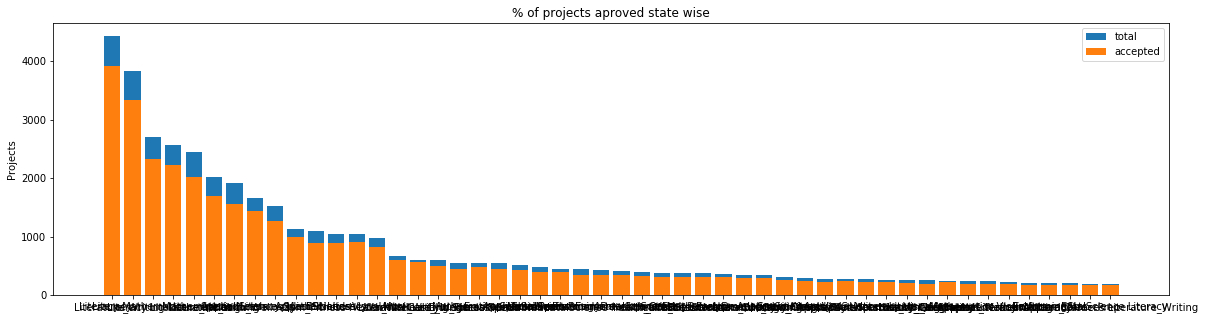

                clean_subcategories  project_is_approved  total       Avg
303                        Literacy                 3919   4434  0.883852
305            Literacy Mathematics                 3336   3833  0.870337
317  Literature_Writing Mathematics                 2331   2705  0.861738
304     Literacy Literature_Writing                 2217   2570  0.862646
327                     Mathematics                 2013   2441  0.824662
                    clean_subcategories  project_is_approved  total       Avg
3    AppliedSciences College_CareerPrep                  169    201  0.840796
367                      PerformingArts                  177    200  0.885000
125                                 ESL                  171    199  0.859296
188       EnvironmentalScience Literacy                  169    195  0.866667
17   AppliedSciences Literature_Writing                  165    188  0.877660


In [23]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [24]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())


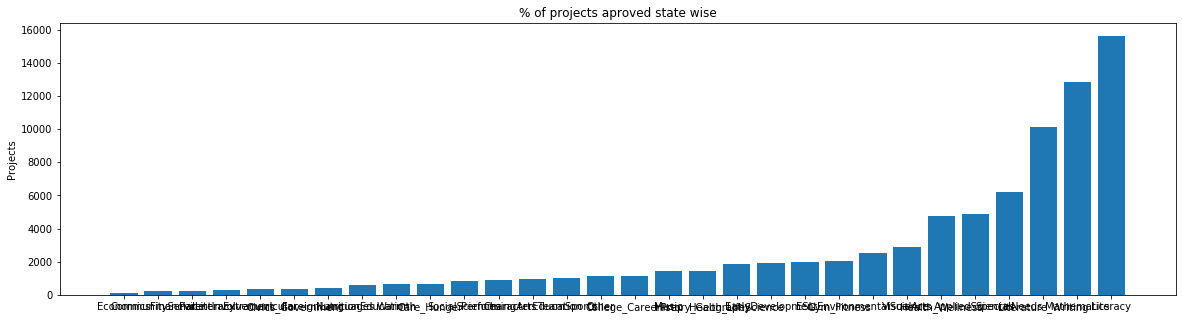

In [25]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [26]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       127
CommunityService     :       214
FinancialLiteracy    :       253
ParentInvolvement    :       302
Extracurricular      :       373
Civics_Government    :       380
ForeignLanguages     :       388
NutritionEducation   :       617
Warmth               :       643
Care_Hunger          :       643
SocialSciences       :       864
PerformingArts       :       910
CharacterEducation   :       958
TeamSports           :       995
Other                :      1128
College_CareerPrep   :      1168
Music                :      1432
History_Geography    :      1433
Health_LifeScience   :      1876
EarlyDevelopment     :      1937
ESL                  :      1999
Gym_Fitness          :      2068
EnvironmentalScience :      2533
VisualArts           :      2865
Health_Wellness      :      4732
AppliedSciences      :      4901
SpecialNeeds         :      6233
Literature_Writing   :     10127
Mathematics          :     12832
Literacy             :     15611


In [27]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [28]:
approved_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values
rejected_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values
word_count = project_data['project_title'].str.split().apply(len) #add column word_column


In [29]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

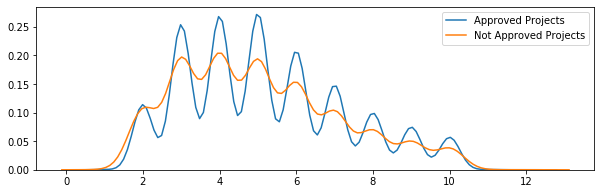

In [30]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.legend()
plt.show()

In [31]:
# merge all essay columns into project_data["essay"] column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [32]:
project_data.columns

Index(['id', 'teacher_prefix', 'school_state', 'project_grade_category',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

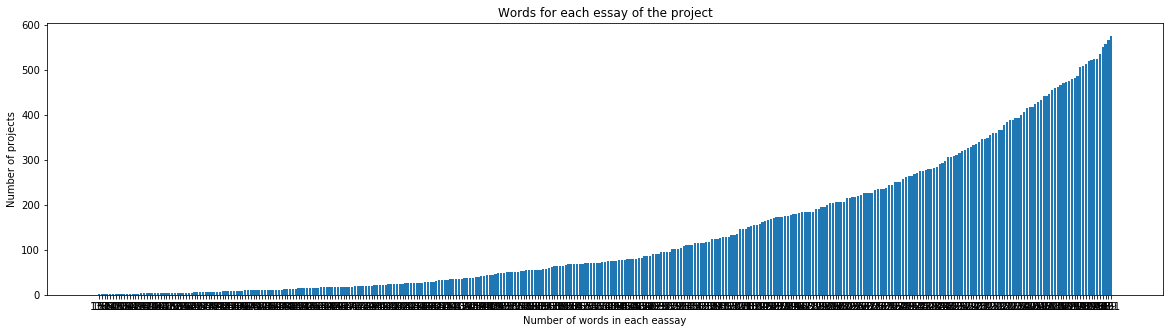

In [33]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in each eassay')
plt.title('Words for each essay of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

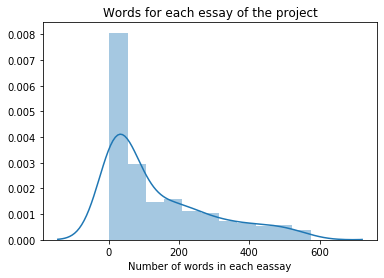

In [34]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()

In [35]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values
rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

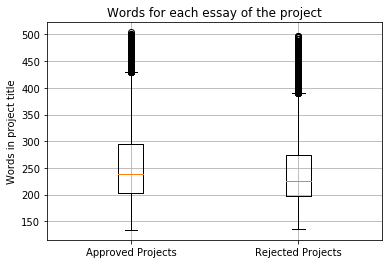

In [36]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

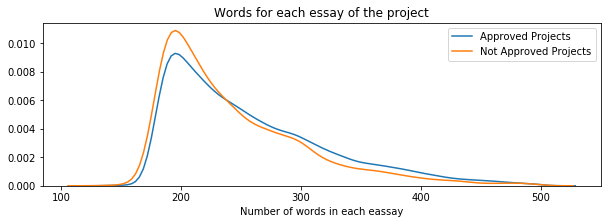

In [37]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

In [38]:
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [39]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [40]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [41]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values
rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

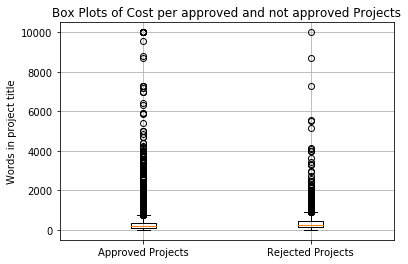

In [42]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

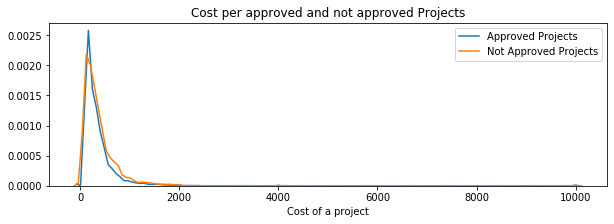

In [43]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [44]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.772      |         41.429        |
|     10     |       33.99       |         73.18         |
|     15     |       58.57       |         98.548        |
|     20     |       78.64       |        118.006        |
|     25     |       99.99       |        140.785        |
|     30     |      117.035      |        161.972        |
|     35     |       137.08      |        183.825        |
|     40     |       157.0       |        208.726        |
|     45     |      177.802      |        234.921        |
|     50     |      198.085      |        261.255        |
|     55     |      221.808      |        292.798        |
|     60     |       254.0       |        322.998        |
|     65     |      283.812      |        359.934       

1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects


In [45]:
project_data[project_data['teacher_number_of_previously_posted_projects']==project_data['teacher_number_of_previously_posted_projects'].max()]
# row of max value of teacher_number_of_previously_posted_projects row

id teacher_prefix school_state project_grade_category  \
13777  p136261           Mrs.           PA          Grades PreK-2   

                                    project_title  \
13777  Life Essential Dried Fruits to the Rescue!   

                                         project_essay_1  \
13777  I currently have 25 six- and seven-year-old st...   

                                         project_essay_2 project_essay_3  \
13777  My first graders ask me everyday if they can b...             NaN   

      project_essay_4                           project_resource_summary  \
13777             NaN  My students need L  Life Essential foods such ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
13777                                           428                    1   

         clean_categories clean_subcategories  \
13777  Warmth Care_Hunger  Warmth Care_Hunger   

                                                   essay   price  quantity  
13777  I currently have 25 six- and seven-year-old st...  134.88         7

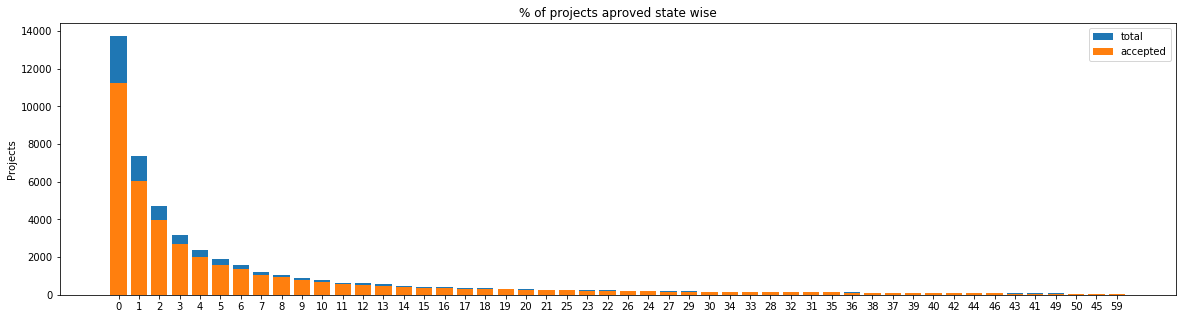

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                11260  13735   
1                                             1                 6055   7352   
2                                             2                 3944   4709   
3                                             3                 2690   3199   
4                                             4                 2032   2399   

        Avg  
0  0.819803  
1  0.823585  
2  0.837545  
3  0.840888  
4  0.847020  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
41                                            41                   64     71   
49                                            49                   62     69   
50                                            50                   61     66   
45                                            45                   58     64   
59                                       

In [46]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved',50 )

In [47]:
approved_project = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values
rejected_project = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values


Teachers having more previous project proposals have greater chance of project approvals.

In [48]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Percentile", "Approved_Project", "rejected_Project"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_project,i), 3), np.round(np.percentile(rejected_project,i), 3)])
print(x)

+------------+------------------+------------------+
| Percentile | Approved_Project | rejected_Project |
+------------+------------------+------------------+
|     0      |       0.0        |       0.0        |
|     5      |       0.0        |       0.0        |
|     10     |       0.0        |       0.0        |
|     15     |       0.0        |       0.0        |
|     20     |       0.0        |       0.0        |
|     25     |       0.0        |       0.0        |
|     30     |       1.0        |       0.0        |
|     35     |       1.0        |       1.0        |
|     40     |       1.0        |       1.0        |
|     45     |       2.0        |       1.0        |
|     50     |       2.0        |       2.0        |
|     55     |       3.0        |       2.0        |
|     60     |       4.0        |       3.0        |
|     65     |       5.0        |       3.0        |
|     70     |       7.0        |       4.0        |
|     75     |       10.0       |       6.0   

the table shows as the teacher_number_of_previously_posted_projects increases the chance of project approval increases significantly.

In [49]:
import re
digit_in_summary=[]
summary_array=project_data["project_resource_summary"].values
for i in summary_array:
    digit=re.search(r'\d', i)
    if (bool(digit)==False):
        digit_in_summary.append(0)
    else:
        digit_in_summary.append(1)
project_data['digits_in_summary'] = digit_in_summary
project_data['digits_in_summary'].value_counts()#false=0 and true =1 in bool(digit_summary)

0    42918
1     7082
Name: digits_in_summary, dtype: int64

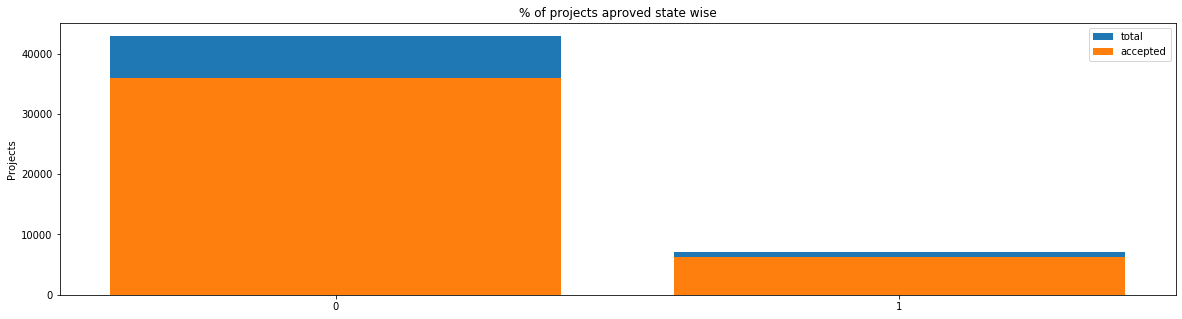

   digits_in_summary  project_is_approved  total       Avg
0                  0                35953  42918  0.837714
1                  1                 6333   7082  0.894239
   digits_in_summary  project_is_approved  total       Avg
0                  0                35953  42918  0.837714
1                  1                 6333   7082  0.894239


In [50]:
univariate_barplots(project_data, 'digits_in_summary', 'project_is_approved', top=False)


if digit present in project_summary high chance that project is approved 

In [51]:
project_row_0=project_data["essay"].values[0]
project_row_0

'My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \\r\\n\\r\\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\\"The limits of your language are the limits of your world.\\"-Ludwig Wittgenstein  Our English learner\'s have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\\r\\n\\r\\nBy providing these dvd\'s and players, st

In [52]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [53]:
# https://stackoverflow.com/a/47091490/4084039
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [54]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [55]:
#preprocess title 
#delete  "project_title" column and add preprocessed_titles
preprocessed_titles=[]
for sentence in tqdm(project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
project_data['projects_title']=preprocessed_titles
project_data.drop('project_title', axis=1,inplace=True)


100%|██████████| 50000/50000 [00:02<00:00, 24830.10it/s]


In [56]:
project_data.columns

Index(['id', 'teacher_prefix', 'school_state', 'project_grade_category',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digits_in_summary', 'projects_title'],
      dtype='object')

In [57]:
print("printing some random reviews")
print(9, project_data['projects_title'].values[9])
print(34, project_data['projects_title'].values[34])
print(147, project_data['projects_title'].values[147])

printing some random reviews
9 just for love reading pure pleasure
34 have a ball
147 who needs chromebook we do


In [58]:
preprocessed_essays=[]#preprocess essay column  and append to project_data
for sentence in tqdm(project_data['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['essays']=preprocessed_essays


100%|██████████| 50000/50000 [00:35<00:00, 1413.18it/s]


In [59]:
#random preprocessed array
print(project_data["essays"][3])
print(project_data["essays"][10])
print(project_data["essays"][13])



i work unique school filled esl (english second language) high poverty students. our students individual personal struggles would break heart step doors would not notice anything positive resilient attitude learning. my students love support every aspect learning journey. we students all world speaking 77 different languages like family. every student welcomed open arms regardless come language speak. education love universal language classroom plenty both!my students live high poverty conditions limited no access technology. ipads provide opportunity learn playing reading math games engage inspire. these ipads surely hottest commodity classroom students beg get play educational games. i tracking data ipad several educational programs help differentiate learning student. students also able track progress programs. i look forward seeing students grow use ipads!nannan
there many little ways enlarge world. love books best all.” - jacqueline kennedy i work title 1 school serves students lo

In [60]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

In [61]:
#preprocessing grade category
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    20316
grades_3_5       16968
grades_6_8        7750
grades_9_12       4966
Name: project_grade_category, dtype: int64

In [62]:
project_data['teacher_prefix'].value_counts()

Mrs.       26140
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64

In [63]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 2


In [64]:
#fill missing values with "Mrs." and convert to lowercase as most have mrs. prefix on them
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        26142
ms         17936
mr          4859
teacher     1061
dr             2
Name: teacher_prefix, dtype: int64

In [65]:
#preprocessing school state converting to lowercase
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    7024
ny    3393
tx    3320
fl    2839
nc    2340
il    1967
sc    1830
ga    1828
mi    1468
pa    1419
oh    1180
in    1171
mo    1166
wa    1103
la    1094
ma    1076
ok    1074
nj    1005
az     994
va     916
wi     833
ut     792
al     790
tn     774
ct     774
md     668
nv     665
ky     614
ms     598
or     577
mn     556
co     538
ar     446
ia     306
id     302
ks     285
dc     247
hi     239
nm     236
me     222
wv     218
de     155
ak     153
ne     144
sd     142
nh     141
ri     126
mt     106
nd      63
wy      51
vt      32
Name: school_state, dtype: int64

In [66]:
project_data.columns

Index(['id', 'teacher_prefix', 'school_state', 'project_grade_category',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digits_in_summary', 'projects_title', 'essays'],
      dtype='object')

In [67]:
project_data.drop('project_essay_1', axis=1,inplace=True)
project_data.drop('project_essay_2', axis=1,inplace=True)
project_data.drop('project_essay_3', axis=1,inplace=True)
project_data.drop('project_essay_4', axis=1,inplace=True)
project_data.drop('essay', axis=1,inplace=True)
project_data.drop('id', axis=1,inplace=True)

project_data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price', 'quantity',
       'digits_in_summary', 'projects_title', 'essays'],
      dtype='object')

In [68]:
#adding count of words in essay feature 
word_count=[]
for i in project_data["essays"].values:
    c=0
    for k in i.split():
        c+=1
    word_count.append(c)
project_data['word_count'] = word_count
project_data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price', 'quantity',
       'digits_in_summary', 'projects_title', 'essays', 'word_count'],
      dtype='object')

In [69]:
X=project_data.loc[:, project_data.columns != 'project_is_approved']
y=project_data['project_is_approved']
X.shape

(50000, 13)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify = y)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(33500, 13)
(16500, 13)
(33500,)
(16500,)


In [104]:
# we use count vectorizer to convert the values into one hot vectors 
#convertion to vector
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cat = CountVectorizer( lowercase=True, binary=True)
vectorizer_cat.fit(X_train['clean_categories'].values)
categories_train = vectorizer_cat.transform(X_train['clean_categories'].values)
categories_test = vectorizer_cat.transform(X_test['clean_categories'].values)
print(vectorizer_cat.get_feature_names())
print("Train data ",categories_train.shape)
print("Test data ",categories_test.shape)
features_bow=[]
features_bow.extend(vectorizer_cat.get_feature_names())

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Train data  (33500, 9)
Test data  (16500, 9)


In [105]:
#convert subcategories to vector
vectorizer_sub = CountVectorizer(lowercase=True, binary=True)
vectorizer_sub.fit(X_train['clean_subcategories'].values)
sub_train = vectorizer_sub.transform(X_train['clean_subcategories'].values)
sub_test = vectorizer_sub.transform(X_test['clean_subcategories'].values)
print(vectorizer_sub.get_feature_names())
print("Train data",sub_train.shape)
print("Test data",sub_test.shape)
features_bow.extend(vectorizer_sub.get_feature_names())

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
Train data (33500, 30)
Test data (16500, 30)


In [106]:
## school_state to vector
vectorizer_school = CountVectorizer(lowercase=True,binary=True)
vectorizer_school.fit(X_train['school_state'].values) # fit has to happen only on train data
X_train_state_ohe = vectorizer_school.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_school.transform(X_test['school_state'].values)
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_school.get_feature_names())
print("="*100)
features_bow.extend(vectorizer_school.get_feature_names())

(33500, 51) (33500,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [107]:
#one hot encodeing to project_grade_category
vectorizer = CountVectorizer(lowercase="True",binary=True)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)
features_bow.extend(vectorizer.get_feature_names())

(33500, 4) (33500,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [108]:
#one hot encoding for teacher_prefix
vectorizer_teacher = CountVectorizer(lowercase=True,binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_teacher.transform(X_test['teacher_prefix'].values)
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_teacher.get_feature_names())
print("="*100)
features_bow.extend(vectorizer_teacher.get_feature_names())

(33500, 5) (33500,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [109]:
#bow on preprocessed  train ,test ,cv essay data
vectorizer_bow_essay = CountVectorizer(min_df=10)  #selecting top 5000 features
vectorizer_bow_essay.fit(X_train["essays"])
bow_train = vectorizer_bow_essay.transform(X_train["essays"].values)
bow_test = vectorizer_bow_essay.transform(X_test["essays"].values)
print("train_shape", bow_train.shape)
print("test_shape ",bow_test.shape)
print((vectorizer_bow_essay.get_feature_names())[:5])
print("="*50)
features_bow.extend(vectorizer_bow_essay.get_feature_names())

train_shape (33500, 10466)
test_shape  (16500, 10466)
['00', '000', '10', '100', '1000']


In [78]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))
X_train_price = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price = normalizer.transform(X_test['price'].values.reshape(1,-1))
X_train_price=X_train_price.reshape(-1,1)
X_test_price=X_test_price.reshape(-1,1)
print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)
print("="*100)


(33500, 1) (33500,)
(16500, 1) (16500,)


In [79]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_teacher_number = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_teacher_number=(X_train_teacher_number.reshape(-1,1))
X_test_teacher_number=(X_test_teacher_number.reshape(-1,1))
print(X_train_teacher_number.shape, y_train.shape)
print(X_test_teacher_number.shape, y_test.shape)
print("="*100)

(33500, 1) (33500,)
(16500, 1) (16500,)


In [ ]:
project_data.columns

In [80]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['word_count'].values.reshape(1,-1))
X_train_word_count = normalizer.transform(X_train['word_count'].values.reshape(1,-1))
X_test_word_count = normalizer.transform(X_test['word_count'].values.reshape(1,-1))
X_train_word_count=(X_train_word_count.reshape(-1,1))
X_test_word_count=(X_test_word_count.reshape(-1,1))
print(X_train_word_count.shape, y_train.shape)
print(X_test_word_count.shape, y_test.shape)
print("="*100)

(33500, 1) (33500,)
(16500, 1) (16500,)


In [81]:
normalizer = Normalizer()
normalizer.fit(X_train['digits_in_summary'].values.reshape(1,-1))
X_train_digit=normalizer.transform(X_train['digits_in_summary'].values.reshape(1,-1))
X_test_digit = normalizer.transform(X_test['digits_in_summary'].values.reshape(1,-1))
X_train_digit=(X_train_digit.reshape(-1,1))
X_test_digit=(X_test_digit.reshape(-1,1))
print(X_train_digit.shape, y_train.shape)
print(X_test_digit.shape, y_test.shape)
print("="*100)

(33500, 1) (33500,)
(16500, 1) (16500,)


In [82]:
from scipy.sparse import hstack# merging all features
X_train_bow = hstack((categories_train,sub_train,X_train_state_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_teacher_number ,X_train_price, X_train_word_count,X_train_digit ,bow_train)).tocsr()
X_test_bow =hstack((categories_test,sub_test,X_test_state_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_teacher_number ,X_test_price, X_test_word_count,X_test_digit , bow_test)).tocsr()

print(" data matrix for bag of word on preprocessed essay")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

 data matrix for bag of word on preprocessed essay
(33500, 10569) (33500,)
(16500, 10569) (16500,)


In [83]:
#SET-2 tf-idf on preprocessed essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essays'])
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf=vectorizer.transform(X_train['essays'].values)
X_test_tfidf=vectorizer.transform(X_test['essays'].values)
print(X_train_tfidf.shape)


(33500, 10466)


In [84]:
#merging features for set-2 
#concatenating all features
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_train_2 = hstack((categories_train,sub_train,X_train_state_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_teacher_number ,X_train_price, X_train_word_count ,X_train_tfidf)).tocsr()
X_test_2 =hstack((categories_test,sub_test,X_test_state_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_teacher_number ,X_test_price, X_test_word_count , X_test_tfidf)).tocsr()
print("data matrix with tfidf on preprocessed essay")
print(X_train_2.shape, y_train.shape)
print(X_test_2.shape, y_test.shape)
print("="*100)

data matrix with tfidf on preprocessed essay
(33500, 10568) (33500,)
(16500, 10568) (16500,)


In [85]:
#https://github.com/joelvarma/Naive-Bayes-DonorsChoose.org
def pre(clf, data):#predict proba of each datapoint
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import math
nb = MultinomialNB(class_prior=[0.5,0.5])
train_auc = []
cv_auc = []
log_alpha = []
alpha=[ 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10, 50, 100]
parameters={'alpha':[ 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10, 50, 100]}
nb = MultinomialNB(class_prior=[0.5,0.5])
clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True)
clf.fit(X_train_bow, y_train)
for i in np.log(alpha):
    log_alpha.append(i)
clf

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10,
                                   50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [87]:
#Output of GridSearchCV
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('='*75)
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.7005400443543034
k value with best score:  {'alpha': 0.5}
Train AUC scores
[0.84167449 0.8406648  0.83580019 0.83024132 0.82685392 0.81355718
 0.74402554 0.70348607 0.57174167 0.50635943]
CV AUC scores
[0.6784237  0.68101831 0.69003117 0.69594709 0.69806815 0.70054004
 0.66986104 0.6464497  0.55413374 0.50463692]


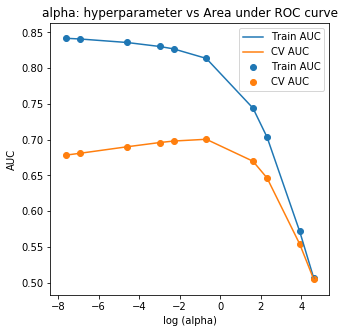

In [88]:
plt.figure(figsize=(5,5))
plt.plot(log_alpha,clf.cv_results_['mean_train_score'], label='Train AUC')
plt.plot(log_alpha, clf.cv_results_['mean_test_score'], label='CV AUC')
plt.scatter(log_alpha, clf.cv_results_['mean_train_score'], label='Train AUC')#train auc
plt.scatter(log_alpha, clf.cv_results_['mean_test_score'], label='CV AUC ')#validation auc 
plt.legend()
plt.xlabel("log (alpha)")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter vs Area under ROC curve")
plt.show()

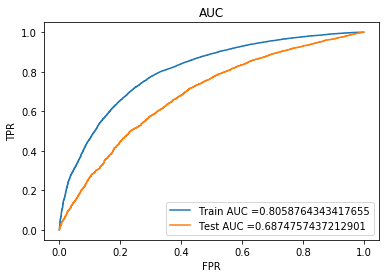

In [89]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
nb_bow = MultinomialNB(alpha = 0.5,class_prior = [0.5,0.5])
nb_bow.fit(X_train_bow, y_train)
y_train_pred = pre(nb_bow,X_train_bow)
y_test_pred = pre(nb_bow,X_test_bow)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.show()

In [90]:
#confusion matrix
from sklearn.metrics import confusion_matrix
def predict(proba, thresh, fpr, tpr):
    t = thresh[np.argmax(fpr*(1-tpr))]#finding best threshold
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
print("="*100)
print("Testconfusion matrix")
c=confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_tpr))
print(c)

Testconfusion matrix
[[1681  865]
 [5378 8576]]


Test data confusion matrix


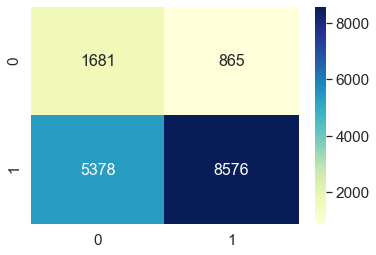

In [92]:
print("Test data confusion matrix")

sns.set(font_scale=1.4)
sns.heatmap(c, annot=True,annot_kws={"size": 16}, fmt='g',cmap="YlGnBu")

In [ ]:
#set 2 with tfidf
train_auc_2 = []
cv_auc_2 = []
log_alpha_2 =[]
alpha=[ 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10, 50, 100]

for i in tqdm(alpha):
    nb = MultinomialNB(alpha = i,class_prior=[0.5,0.5])
    nb.fit(X_train_2, y_train)
    y_train_pred =pre(nb, X_train_2)    
    y_cv_pred = pre(nb, X_cv_2)
    train_auc_2.append(roc_auc_score(y_train,y_train_pred))
    cv_auc_2.append(roc_auc_score(y_cv, y_cv_pred))
for a in (alpha):
    b = math.log(a)
    log_alpha_2.append(b)

In [95]:
#gridsearch CV with k=10
log_alpha_2=[]
nb = MultinomialNB(class_prior=[0.5,0.5])
parameters={'alpha':[ 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10, 50, 100]}
clf = GridSearchCV(nb, parameters, cv= 10, scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_train_2, y_train)
for a in (alpha):
    b = math.log(a)
    log_alpha_2.append(b)
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
clf

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 5, 10,
                                   50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [96]:
print('Best score: ',clf.best_score_)
print('k value with best score: ',clf.best_params_)
print('='*75)
print('Train AUC scores')
print(clf.cv_results_['mean_train_score'])
print('CV AUC scores')
print(clf.cv_results_['mean_test_score'])

Best score:  0.6703162711544653
k value with best score:  {'alpha': 0.05}
Train AUC scores
[0.82808775 0.82643022 0.8173867  0.80337101 0.79194798 0.73320711
 0.59387466 0.5663287  0.53378627 0.52800526]
CV AUC scores
[0.65413844 0.65705475 0.66657487 0.67031627 0.66893697 0.64421487
 0.56463299 0.5478115  0.52728097 0.52371367]


In [97]:
plt.figure(figsize=(5,5))
plt.plot(log_alpha_2, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.plot(log_alpha_2, cv_auc, label='CV AUC')
plt.scatter(log_alpha_2, train_auc, label='Train AUC points')
plt.scatter(log_alpha_2, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log (alpha)")
plt.ylabel("AUC")
plt.title("hyperparameter vs AUC")
plt.grid()
plt.show()

In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
nb_tfidf = MultinomialNB(alpha = 0.05,class_prior = [0.5,0.5])
nb_tfidf.fit(X_train_2, y_train)
y_train_pred = pre(nb_tfidf,X_train_2)
y_test_pred = pre(nb_tfidf,X_test_2)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

In [101]:
print("Testconfusion matrix")
c=confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_tpr))

sns.set(font_scale=1.4)
sns.heatmap(c, annot=True,annot_kws={"size": 16}, fmt='g',cmap="YlGnBu")

Testconfusion matrix


In [113]:
neg_class_prob_sorted = abs(nb_bow.feature_log_prob_[0, :].argsort())   #class 0
pos_class_prob_sorted = abs(nb_bow.feature_log_prob_[1, :].argsort()) 
print(neg_class_prob_sorted[-20:],pos_class_prob_sorted[-20:])


[ 7642  5876  5710   282  1973 10461  6299 10289  5828  6259  9479  4548
  9510  5505  6405  1852  6244  5509  8279  9127] [  282  2533  5710 10046 10461  7642  6299 10289  6259  5828  4548  5505
  6405  9510  9479  1852  5509  6244  8279  9127]


In [116]:

print('Top 20 features from negative class in set 1:')
print(np.take(features_bow, neg_class_prob_sorted[-20:]))
print('*'*50)
print('Top 20 features from positive class in set 1:')
print(np.take(features_bow, pos_class_prob_sorted[-20:]))

Top 10 features from negative class:
['real' 'mathematical' 'lovers' 'above' 'comfort' 'worker' 'needle'
 'wealth' 'marble' 'narrator' 'theatrical' 'helpful' 'thin' 'learning'
 'note' 'clean' 'myself' 'leather' 'schools' 'study']
**************************************************
Top 10 features from positive class:
['above' 'de' 'lovers' 'user' 'worker' 'real' 'needle' 'wealth' 'narrator'
 'marble' 'helpful' 'learning' 'note' 'thin' 'theatrical' 'clean'
 'leather' 'myself' 'schools' 'study']


In [117]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Test-AUC"]
x.add_row(["BOW", "Naive Bayes", 0.5, 0.687])
x.add_row(["TFIDF", "Naive Bayes", 0.1, 0.662])
print(x)

+------------+-------------+----------------+----------+
| Vectorizer |    Model    | Hyperparameter | Test-AUC |
+------------+-------------+----------------+----------+
|    BOW     | Naive Bayes |      0.5       |  0.687   |
|   TFIDF    | Naive Bayes |      0.1       |  0.662   |
+------------+-------------+----------------+----------+
